In [60]:
import cv2
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as tfl
import os
import pandas as pd
import matplotlib.pyplot as plt


In [61]:
COLORS=pd.read_csv("CamVid/class_dict.csv")
COLORS=COLORS[["r","g","b"]].to_numpy()

COLORS={tuple(value):key for key,value in enumerate(COLORS)}
print(len(COLORS))

32


In [62]:
TRAIN_IMAGE_PATH="C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/train/"
TRAIN_MASK_PATH="C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/train_labels/"
VALID_IMAGE_PATH="C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/val/"
VALID_MASK_PATH="C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/val_labels/"

In [63]:
train_image_list_orig=os.listdir(TRAIN_IMAGE_PATH)
train_mask_list_orig=os.listdir(TRAIN_MASK_PATH)

train_image_list=[TRAIN_IMAGE_PATH+i for i in train_image_list_orig]
train_mask_list=[TRAIN_MASK_PATH+i for i in train_mask_list_orig]

valid_image_list_orig=os.listdir(VALID_IMAGE_PATH)
valid_mask_list_orig=os.listdir(VALID_MASK_PATH)

valid_image_list=[VALID_IMAGE_PATH+i for i in valid_image_list_orig]
valid_mask_list=[VALID_MASK_PATH+i for i in valid_mask_list_orig]

### Sample Images And Masks


(720, 960, 3)
(720, 960, 3)


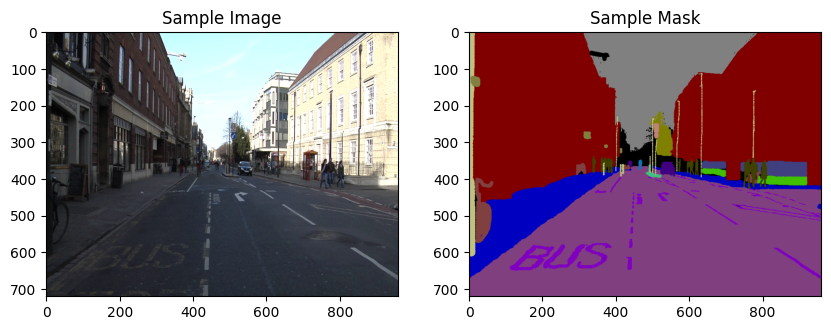

In [ ]:
img=cv2.imread(valid_image_list[50])
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

mask=cv2.imread(valid_mask_list[50])
mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Sample Image")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Sample Mask")

print(img.shape)
print(mask.shape)

In [65]:
train_image_filenames=tf.constant(train_image_list)
train_mask_filenames=tf.constant(train_mask_list)

valid_image_filenames=tf.constant(valid_image_list)
valid_mask_filenames=tf.constant(valid_mask_list)

train_dataset=tf.data.Dataset.from_tensor_slices((train_image_filenames,train_mask_filenames))
valid_dataset=tf.data.Dataset.from_tensor_slices((valid_image_filenames,valid_mask_filenames))


In [66]:
for image,mask in valid_dataset.take(4):
    print(image)
    print(mask)
    print()

tf.Tensor(b'C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/val/0001TP_009030.png', shape=(), dtype=string)
tf.Tensor(b'C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/val_labels/0001TP_009030_L.png', shape=(), dtype=string)

tf.Tensor(b'C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/val/0001TP_009060.png', shape=(), dtype=string)
tf.Tensor(b'C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/val_labels/0001TP_009060_L.png', shape=(), dtype=string)

tf.Tensor(b'C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convo

In [67]:
mask=tf.io.read_file(train_mask_list[0])
mask=tf.image.decode_png(mask,channels=3)

class_mask=tf.zeros([mask.shape[0],mask.shape[1]])

for color,class_id in COLORS.items():
    boolean=tf.reduce_all(mask==color,axis=-1)
    class_mask=tf.where(boolean,class_id,class_mask)

class_mask=tf.cast(class_mask,tf.int32)
class_mask

<tf.Tensor: shape=(720, 960), dtype=int32, numpy=
array([[21, 21, 21, ..., 26, 26, 26],
       [21, 21, 21, ..., 26, 26, 26],
       [21, 21, 21, ..., 26, 26, 26],
       ...,
       [19, 19, 19, ..., 30, 30, 30],
       [19, 19, 19, ..., 30, 30, 30],
       [19, 19, 19, ..., 30, 30, 30]])>

In [ ]:
def rgb_to_class(mask):
    
    class_mask=tf.zeros([mask.shape[0],mask.shape[1]],dtype=tf.int32)

    for color,class_id in COLORS.items():
        boolean=tf.reduce_all(mask==color,axis=-1)
        class_mask=tf.where(boolean,class_id,class_mask)

    class_mask=tf.cast(class_mask,tf.int32)
    return class_mask

def process_path(img_path,mask_path):
    img=tf.io.read_file(img_path)
    img=tf.image.decode_png(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)

    mask=tf.io.read_file(mask_path)
    mask=tf.image.decode_png(mask,channels=3)
    
    return img,mask

def preprocess(img,mask):
    final_img=tf.image.resize(img,[96,128],method="nearest")
    final_mask=tf.image.resize(mask,[96,128],method="nearest")
    final_mask=rgb_to_class(final_mask)

    return final_img,final_mask

In [69]:
train_image_ds=train_dataset.map(process_path)
processed_train_ds=train_image_ds.map(preprocess)

valid_image_ds=valid_dataset.map(process_path)
processed_valid_datset=valid_image_ds.map(preprocess)

In [70]:
print(train_image_ds)
print()
print(processed_valid_datset)

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None))>

<MapDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128), dtype=tf.int32, name=None))>


In [71]:
def conv_block(input=None,n_filters=32,dropout_prob=0,max_pool=True):

    conv=tfl.Conv2D(n_filters,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(input)
    conv=tfl.Conv2D(n_filters,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(conv)

    if(dropout_prob>0):
        conv=tfl.Dropout(dropout_prob)(conv)

    if max_pool:
        next_layer=tfl.MaxPool2D((2,2))(conv)

    else:
        next_layer=conv

    skip_connection=conv

    return next_layer,skip_connection

In [ ]:
def up_block(expansive_input,contractive_input,n_filters=64):

    up=tfl.Conv2DTranspose(n_filters,(3,3),padding="same",strides=2)(expansive_input)

    merge=tfl.concatenate([up,contractive_input],axis=3)

    conv=tfl.Conv2D(n_filters,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(merge)
    conv=tfl.Conv2D(n_filters,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(conv)

    return conv

In [73]:
def unet(input_size,n_filters=64,n_classes=32):

    input=tfl.Input(input_size)

    cblock1=conv_block(input,n_filters)
    cblock2=conv_block(cblock1[0],n_filters*2)
    cblock3=conv_block(cblock2[0],n_filters*4)
    cblock4=conv_block(cblock3[0],n_filters*8,dropout_prob=0.3)

    bottleneck=conv_block(cblock4[0],n_filters*16,dropout_prob=0.3,max_pool=False)

    ublock4=up_block(bottleneck[0],cblock4[1],n_filters*8)
    ublock3=up_block(ublock4,cblock3[1],n_filters*4)
    ublock2=up_block(ublock3,cblock2[1],n_filters*2)
    ublock1=up_block(ublock2,cblock1[1],n_filters)

    conv=tfl.Conv2D(n_filters,(3,3),padding="same",activation="relu",kernel_initializer="he_normal")(ublock1)

    output=tfl.Conv2D(n_classes,1,padding="same")(conv)

    model=tf.keras.models.Model(inputs=input,outputs=output)

    return model

In [74]:
unet_model=unet((96,128,3))
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 96, 128, 64)  1792        ['input_3[0][0]']                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 96, 128, 64)  36928       ['conv2d_40[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 48, 64, 64)  0           ['conv2d_41[0][0]']        

In [75]:
unet_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy"]
)

### Training The Model


In [76]:
print(processed_train_ds)
print()
print(processed_valid_datset)

<MapDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128), dtype=tf.int32, name=None))>

<MapDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128), dtype=tf.int32, name=None))>


In [77]:
EPOCHS=100
BUFFER_SIZE=500
BATCH_SIZE=32

train_dataset=processed_train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_dataset=processed_valid_datset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

model_history=unet_model.fit(train_dataset,epochs=EPOCHS,validation_data=valid_dataset)

Epoch 1/100
12/12 [==============================] - 9s 490ms/step - loss: 3.7588 - accuracy: 0.1286 - val_loss: 2.4822 - val_accuracy: 0.1646
Epoch 2/100
12/12 [==============================] - 7s 437ms/step - loss: 2.3320 - accuracy: 0.2891 - val_loss: 2.1260 - val_accuracy: 0.3773
Epoch 3/100
12/12 [==============================] - 7s 444ms/step - loss: 2.0465 - accuracy: 0.4161 - val_loss: 2.1761 - val_accuracy: 0.2323
Epoch 4/100
12/12 [==============================] - 7s 452ms/step - loss: 1.9376 - accuracy: 0.4102 - val_loss: 1.8573 - val_accuracy: 0.5418
Epoch 5/100
12/12 [==============================] - 7s 463ms/step - loss: 1.6167 - accuracy: 0.5567 - val_loss: 1.5172 - val_accuracy: 0.5991
Epoch 6/100
12/12 [==============================] - 7s 464ms/step - loss: 1.3863 - accuracy: 0.6085 - val_loss: 1.3258 - val_accuracy: 0.6221
Epoch 7/100
12/12 [==============================] - 7s 479ms/step - loss: 1.2746 - accuracy: 0.6257 - val_loss: 1.2359 - val_accuracy: 0.6354

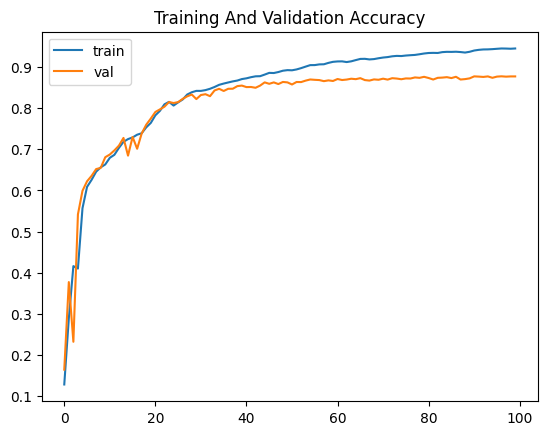

In [152]:
plt.title("Training And Validation Accuracy")
plt.plot(model_history.history["accuracy"],label="train")
plt.plot(model_history.history['val_accuracy'],label="val")
plt.legend()

In [ ]:
# unet_model.save("ImageSegmenter.keras")

## Validating The Model

In [80]:
unet_model.evaluate(valid_dataset)

4/4 [==============================] - 1s 97ms/step - loss: 0.5760 - accuracy: 0.8769


[0.5760184526443481, 0.8769018650054932]

## Testing The Model

In [81]:
TEST_IMAGE_PATH="C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/test/"
TEST_MASK_PATH="C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/test_labels/"

In [82]:
test_image_org=os.listdir(TEST_IMAGE_PATH)
test_mask_org=os.listdir(TEST_MASK_PATH)

test_image_list=[TEST_IMAGE_PATH+i for i in test_image_org]
test_mask_list=[TEST_MASK_PATH+i for i in test_mask_org]

In [83]:
test_image_path=tf.constant(test_image_list)
test_mask_path=tf.constant(test_mask_list)

test_dataset=tf.data.Dataset.from_tensor_slices((test_image_path,test_mask_path))
test_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [84]:
test_ds=test_dataset.map(process_path)
processed_test_ds=test_ds.map(preprocess)

print(processed_test_ds)

<MapDataset element_spec=(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128), dtype=tf.int32, name=None))>


In [85]:
for img,mask in test_dataset.take(1):
    print(img)
    print(mask)

tf.Tensor(b'C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/test/0001TP_006690.png', shape=(), dtype=string)
tf.Tensor(b'C:/Users/PratushPc/OneDrive/Documents/COURSES/DL SPECIALIZATION/4. Convolutional Neural Networks/3. Object Detection - Image Segmentation/Lab/Practice_Image/CamVid/test_labels/0001TP_006690_L.png', shape=(), dtype=string)


In [86]:
test_dataset=processed_test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 128), dtype=tf.int32, name=None))>

In [87]:
for img_batch, mask_batch in test_dataset.take(2):
    print(img_batch.shape, mask_batch.shape)

(32, 96, 128, 3) (32, 96, 128)
(32, 96, 128, 3) (32, 96, 128)


In [125]:
def show_pred(image_path,mask_path,model):
    img,mask=process_path(image_path,mask_path)
    img,class_mask=preprocess(img,mask)

    img=img.numpy()
    class_mask=class_mask.numpy()

    img=np.expand_dims(img,axis=0)
    prediction=model.predict(img,verbose=0)
    img=img[0]
    prediction=prediction[0]
    prediction=np.argmax(prediction,axis=-1)
    
    print(class_mask.shape)
    
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(class_mask)
    plt.title("Actual Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(prediction)
    plt.title("Predicted Mask")
    plt.axis("off")

In [141]:
unet_model.evaluate(test_dataset)

8/8 [==============================] - 2s 127ms/step - loss: 0.9535 - accuracy: 0.8266


[0.9534779787063599, 0.8266057968139648]

(96, 128)


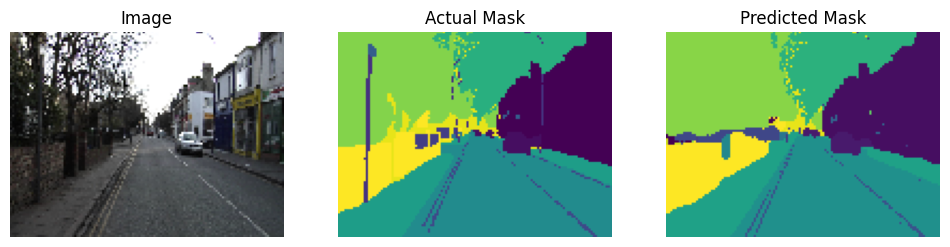

In [156]:
show_pred(test_image_path[200],test_mask_path[200],unet_model)